This notebook is code that has been previously adapted from reserach conduted by Isaac Reid, Krzysztof Choromanski, Adrian Weller in Quasi-Monte Carlo Graph Random Features. Here is the github repository from where the original notebook resides https://github.com/isaac-reid/antithetic_termination. The purpose of our research is to investiagte alternative kernel functions and graph types that achieve a similarly low variance estimation for q-GRFs (utils, fr_constuction, and adjacency_matrix.pkl are files that can be found in Isaac Reid's repository).

In [ ]:
import numpy as np
import random as rnd
import time
import matplotlib
from matplotlib import pyplot as plt
from numpy import array, zeros, diag, diagflat, dot
from math import sqrt
import pprint
import scipy
import scipy.linalg
import os
from tqdm import tqdm
from utils import *
from rf_construction import *
import pickle
import numpy as np
import random

In [ ]:
#Parameters
nb_rnd_walks_list = [2,4,8]     #number of walkers to use to estimate kernel
nb_repeats = 100        #number of repeats to get standard deviations
p_halt = 0.5         #probability of a walker halting at a particular timestep
sigma = 0.1   #regulariser

In [ ]:
#load adjacency matrix arrays for the graphs to be considered
with open('adjacency_matrices.pkl','rb') as f:
    As = pickle.load(f)

2-Regularised Laplacian Kernel (Previosuly studied by https://arxiv.org/abs/2305.12470)


In [ ]:
all_graphs_means = [] #holders for the mean approximation error and corresponding standard deviation
all_graphs_stds = []


for graph_id,A in enumerate(As):
    print('Doing graph %s of %s'%(graph_id+1, len(As)))

    nb_vertices = len(A)    #size of the graph
    L_tilde = get_laplacian_matrix(A)  #see Eq. 24
    U = - sigma**2 / (1+sigma**2) * (L_tilde - np.eye(len(A)))  #see Eq. 26
    M = np.eye(nb_vertices) + sigma**2 * L_tilde
    groundtruth_matrix = np.linalg.inv(M @ M)  #see Eq. 25

    adj_lists, weight_lists = adj_matrix_to_lists(U)  #get lists of neighbours and weights for each edge

    mean_fro_superlist = []  #to hold all the mean Frob norm errors
    std_fro_superlist = []  #to hold their respctive standard devs


    #iid walkers
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling = None)  #create low rank factorisation
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)  #compute product of random features to approximate Gram matrix
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)    #compute the relative Frob norm between the true and approximated Gram matrices
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    #antithetic termination -- repeat the above with our new QMC scheme
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling='antithetic')
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    all_graphs_means.append(mean_fro_superlist)
    all_graphs_stds.append(std_fro_superlist)
    print('')

Doing graph 1 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 2898.46it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1976.29it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 2080.26it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1167.49it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 898.35it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 471.05it/s]



Doing graph 2 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 522.31it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 359.42it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 197.74it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 176.74it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 100.30it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 45.78it/s]



Doing graph 3 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 212.03it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 141.46it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 85.98it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 118.69it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 77.04it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 41.29it/s]



Doing graph 4 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 556.22it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 367.57it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 216.65it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 179.86it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 96.11it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 51.47it/s]



Doing graph 5 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1726.46it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1207.74it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1091.55it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 863.51it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 549.07it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 291.91it/s]



Doing graph 6 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 887.58it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 713.88it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 323.79it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 298.38it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 174.11it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 90.13it/s]



Doing graph 7 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 192.45it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 263.23it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 182.86it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 148.44it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 84.63it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 44.53it/s]



Doing graph 8 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:12<00:00,  7.73it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:29<00:00,  3.41it/s]

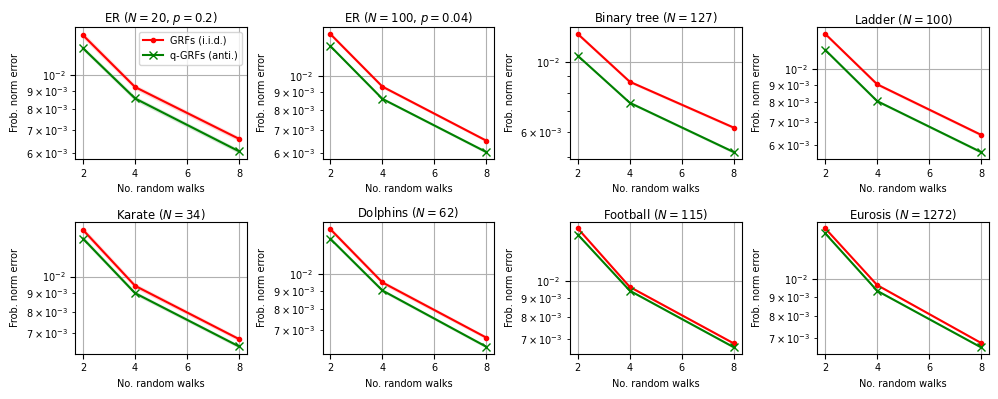

In [ ]:
#Doing all the plots

colors = ['red','green']
markers=['.','x']
labels = ['GRFs (i.i.d.)', 'q-GRFs (anti.)']
plt.rcParams.update({'font.size': 7})

fig, ((ax1, ax2, ax3, ax4),(ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(10,4))

titles = ['ER ($N=20$, $p=0.2$)' ,'ER ($N=100$, $p=0.04$)', 'Binary tree ($N=127$)', 'Ladder ($N=100$)','Karate ($N=34$)','Dolphins ($N=62$)','Football ($N=115$)','Eurosis ($N=1272$)' ]
for graph_id in range(8):
    this_graph_means = all_graphs_means[graph_id]
    this_graph_stds = all_graphs_stds[graph_id]

    plt.subplot(2,4,graph_id+1)

    for ind in range(2):
      meanst = np.array(this_graph_means[ind])
      sdt = np.asarray(this_graph_stds[ind]) / np.sqrt(nb_repeats)
      plt.yscale('log')


      plt.plot(nb_rnd_walks_list, meanst, color = colors[ind], marker = markers[ind], label = labels[ind])
      plt.fill_between(nb_rnd_walks_list, meanst-sdt, meanst+sdt, color = colors[ind],alpha=0.1)

      if graph_id == 0:
         plt.legend()

    plt.title(titles[graph_id],pad=2)
    plt.grid()
    plt.ylabel('Frob. norm error')
    plt.xlabel('No. random walks')

plt.tight_layout()

Diffusion (Heat) Kernels

In [ ]:
import numpy as np
from scipy.linalg import expm
from scipy.sparse.csgraph import laplacian
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import inv

def degree_matrix(adjacency_matrix):
    return np.diag(adjacency_matrix.sum(axis=1))

def unnormalized_laplacian(adjacency_matrix):
    D = degree_matrix(adjacency_matrix)
    return D - adjacency_matrix

def heat_kernel(adjacency_matrix, t=0.5):
    L = unnormalized_laplacian(adjacency_matrix)
    return expm(-t * L)

In [ ]:
#Heat Kernel
seed = 777
np.random.seed(seed)
random.seed(seed)

all_graphs_means = [] #holders for the mean approximation error and corresponding standard deviation
all_graphs_stds = []


for graph_id,A in enumerate(As):
    print('Doing graph %s of %s'%(graph_id+1, len(As)))

    nb_vertices = len(A)    #size of the graph
    L_tilde = heat_kernel(A)  #see Eq. 24
    U = - sigma**2 / (1+sigma**2) * (L_tilde - np.eye(len(A)))  #see Eq. 26
    M = np.eye(nb_vertices) + sigma**2 * L_tilde
    groundtruth_matrix = np.linalg.inv(M @ M)  #see Eq. 25

    adj_lists, weight_lists = adj_matrix_to_lists(U)  #get lists of neighbours and weights for each edge

    mean_fro_superlist = []  #to hold all the mean Frob norm errors
    std_fro_superlist = []  #to hold their respctive standard devs


    #iid walkers
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling = None)  #create low rank factorisation
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)  #compute product of random features to approximate Gram matrix
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)    #compute the relative Frob norm between the true and approximated Gram matrices
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    #antithetic termination -- repeat the above with our new QMC scheme
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling='antithetic')
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    all_graphs_means.append(mean_fro_superlist)
    all_graphs_stds.append(std_fro_superlist)
    print('')

Doing graph 1 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1168.61it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 680.24it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 798.49it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 710.81it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 461.36it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 246.85it/s]



Doing graph 2 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 178.07it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 119.58it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 74.38it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:01<00:00, 82.49it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 59.78it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:03<00:00, 28.89it/s]



Doing graph 3 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 360.83it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 256.66it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 157.04it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 134.39it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 75.27it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:03<00:00, 29.04it/s]



Doing graph 4 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 265.07it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 187.48it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 179.82it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 169.59it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 96.16it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 52.10it/s]



Doing graph 5 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 896.74it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2149.07it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1185.28it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1039.20it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 561.92it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 275.06it/s]



Doing graph 6 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 770.74it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1054.34it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 666.79it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 526.75it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 290.54it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 159.03it/s]



Doing graph 7 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 358.08it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 271.87it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 172.71it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 149.59it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 81.43it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:03<00:00, 26.24it/s]



Doing graph 8 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:13<00:00,  7.63it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:31<00:00,  3.18it/s]

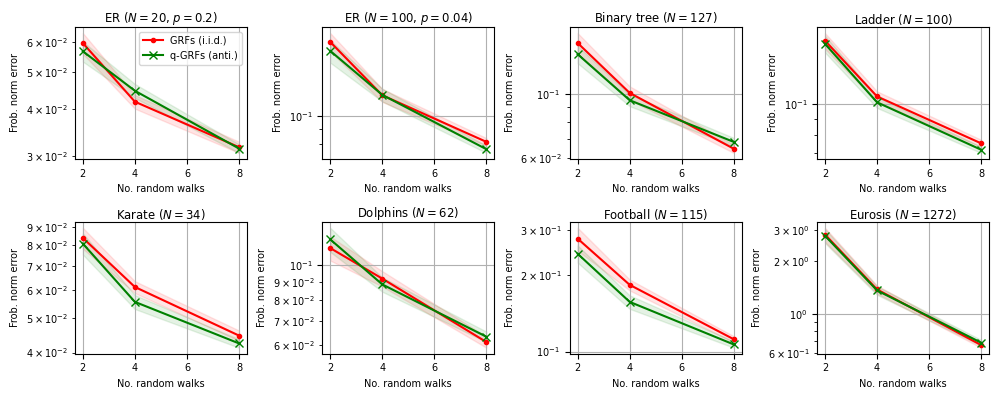

In [ ]:
colors = ['red','green']
markers=['.','x']
labels = ['GRFs (i.i.d.)', 'q-GRFs (anti.)']
plt.rcParams.update({'font.size': 7})

fig, ((ax1, ax2, ax3, ax4),(ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(10,4))

titles = ['ER ($N=20$, $p=0.2$)' ,'ER ($N=100$, $p=0.04$)', 'Binary tree ($N=127$)', 'Ladder ($N=100$)','Karate ($N=34$)','Dolphins ($N=62$)','Football ($N=115$)','Eurosis ($N=1272$)' ]
for graph_id in range(8):
    this_graph_means = all_graphs_means[graph_id]
    this_graph_stds = all_graphs_stds[graph_id]

    plt.subplot(2,4,graph_id+1)

    for ind in range(2):
      meanst = np.array(this_graph_means[ind])
      sdt = np.asarray(this_graph_stds[ind]) / np.sqrt(nb_repeats)
      plt.yscale('log')


      plt.plot(nb_rnd_walks_list, meanst, color = colors[ind], marker = markers[ind], label = labels[ind])
      plt.fill_between(nb_rnd_walks_list, meanst-sdt, meanst+sdt, color = colors[ind],alpha=0.1)

      if graph_id == 0:
         plt.legend()

    plt.title(titles[graph_id],pad=2)
    plt.grid()
    plt.ylabel('Frob. norm error')
    plt.xlabel('No. random walks')

plt.tight_layout()

Erdős–Rényi and Barabási–Albert graphs taken from this github repository https://github.com/tomdbar/eco-dqn

Erdős–Rényi Graphs

In [ ]:
#Parameters
nb_rnd_walks_list = [2,4,8]     #number of walkers to use to estimate kernel
nb_repeats = 100        #number of repeats to get standard deviations
p_halt = 0.5         #probability of a walker halting at a particular timestep
sigma = 0.1   #regulariser

In [ ]:
#load Erdős–Rényi matrix arrays for the graphs to be considered
with open('ER_20spin_p15_50graphs.pkl','rb') as f:
    As = pickle.load(f)

In [ ]:
#Heat Kernel for ER Models 20 SPIN
all_graphs_means = [] #holders for the mean approximation error and corresponding standard deviation
all_graphs_stds = []


for graph_id,A in enumerate(As):
    print('Doing graph %s of %s'%(graph_id+1, len(As)))

    nb_vertices = len(A)
    L_tilde = heat_kernel(A)
    U = - sigma**2 / (1+sigma**2) * (L_tilde - np.eye(len(A)))
    M = np.eye(nb_vertices) + sigma**2 * L_tilde
    groundtruth_matrix = np.linalg.inv(M @ M)

    adj_lists, weight_lists = adj_matrix_to_lists(U)  #get lists of neighbours and weights for each edge

    mean_fro_superlist = []  #to hold all the mean Frob norm errors
    std_fro_superlist = []  #to hold their respctive standard devs


    #iid walkers
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling = None)  #create low rank factorisation
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)  #compute product of random features to approximate Gram matrix
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)    #compute the relative Frob norm between the true and approximated Gram matrices
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    #antithetic termination -- repeat the above with our new QMC scheme
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling='antithetic')
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    all_graphs_means.append(mean_fro_superlist)
    all_graphs_stds.append(std_fro_superlist)
    print('')

Doing graph 1 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1674.24it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1822.33it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 2357.79it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1669.43it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 737.54it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 487.80it/s]



Doing graph 2 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1484.59it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2607.62it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1992.19it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1330.40it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 738.50it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 530.16it/s]



Doing graph 3 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1947.08it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1637.26it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 2400.42it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1983.40it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1227.32it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 609.16it/s]



Doing graph 4 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1709.96it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1668.41it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1864.07it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1642.45it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 909.57it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 522.01it/s]



Doing graph 5 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 2092.92it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1907.05it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 2197.54it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1467.94it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 943.69it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 406.40it/s]



Doing graph 6 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1386.45it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1921.99it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 2219.67it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1734.95it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 880.79it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 453.15it/s]



Doing graph 7 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 2912.27it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1356.53it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1535.48it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1342.14it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 834.81it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 543.33it/s]



Doing graph 8 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1476.98it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2100.66it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1583.68it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1641.64it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1059.85it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 494.94it/s]



Doing graph 9 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1547.78it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2094.88it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1930.32it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1632.95it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 865.77it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 440.93it/s]



Doing graph 10 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1559.73it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2086.62it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1867.27it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1268.55it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 687.88it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 372.44it/s]



Doing graph 11 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1684.18it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1774.85it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1112.00it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 809.30it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 437.74it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 265.71it/s]



Doing graph 12 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1243.21it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2104.85it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1230.92it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 882.48it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 521.08it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 148.90it/s]



Doing graph 13 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 384.93it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 356.79it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 368.65it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1144.59it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1037.03it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 443.93it/s]



Doing graph 14 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1425.62it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2553.47it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 2003.21it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1587.80it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 865.26it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 500.14it/s]



Doing graph 15 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1714.96it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2470.39it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1309.01it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1191.17it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 611.92it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 451.61it/s]



Doing graph 16 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1527.70it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2202.98it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1957.37it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1625.08it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 869.25it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 401.61it/s]



Doing graph 17 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 2438.11it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1803.21it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 2155.62it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1496.84it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 870.68it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 452.41it/s]



Doing graph 18 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1577.52it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2306.73it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1772.55it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1066.88it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 712.92it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 465.01it/s]



Doing graph 19 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1595.79it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2685.76it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 2320.72it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1493.05it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1035.31it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 387.93it/s]



Doing graph 20 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1380.10it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2376.55it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 2014.10it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1496.75it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 863.88it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 488.54it/s]



Doing graph 21 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 2610.07it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1968.08it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 2164.89it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1234.48it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 639.02it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 462.84it/s]



Doing graph 22 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 2590.61it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1784.67it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 2029.61it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1593.73it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 914.39it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 477.91it/s]



Doing graph 23 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1566.14it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1829.44it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1809.07it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1610.67it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 865.18it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 515.62it/s]



Doing graph 24 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 2818.37it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1303.66it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1805.61it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1640.11it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 718.71it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 408.85it/s]



Doing graph 25 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 2779.58it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2082.50it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 2318.92it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1630.44it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1043.20it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 554.75it/s]



Doing graph 26 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 2596.21it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1952.20it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1694.78it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1319.08it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 847.17it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 522.13it/s]



Doing graph 27 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 3207.02it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2120.53it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 2260.12it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1681.89it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1037.74it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 499.56it/s]



Doing graph 28 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1437.34it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2751.59it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1469.26it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1669.81it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 985.58it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 526.30it/s]



Doing graph 29 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1479.93it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1680.69it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1279.06it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 853.26it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 533.51it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 282.80it/s]



Doing graph 30 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1078.90it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1929.20it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1188.77it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 852.20it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 522.22it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 272.85it/s]



Doing graph 31 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1417.11it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1557.04it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1194.27it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 995.64it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 495.47it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 289.26it/s]



Doing graph 32 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1500.73it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1435.93it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1335.07it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 866.90it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 656.86it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 630.97it/s]



Doing graph 33 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1604.08it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2381.14it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1774.28it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1640.94it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 978.07it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 543.03it/s]



Doing graph 34 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 2660.89it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1874.32it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1573.95it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1030.79it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 903.24it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 474.17it/s]



Doing graph 35 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 2554.23it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1552.15it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1799.10it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1646.78it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 862.77it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 409.30it/s]



Doing graph 36 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1877.75it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1580.17it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1924.45it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1446.16it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 784.52it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 491.54it/s]



Doing graph 37 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1970.13it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1847.64it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1464.78it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1134.07it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 839.39it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 472.64it/s]



Doing graph 38 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1480.23it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2269.80it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1924.56it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1646.94it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 892.19it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 430.39it/s]



Doing graph 39 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1649.68it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2168.04it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1894.31it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1450.13it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 759.84it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 481.30it/s]



Doing graph 40 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1744.69it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1904.61it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1432.55it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1366.10it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1007.96it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 511.06it/s]



Doing graph 41 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1541.24it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1529.95it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1807.69it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1520.57it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 910.35it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 411.64it/s]



Doing graph 42 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1504.15it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2088.97it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1239.17it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 951.65it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 813.45it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 462.05it/s]



Doing graph 43 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1346.67it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2060.20it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1429.21it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1411.21it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 772.64it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 457.19it/s]



Doing graph 44 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 2389.73it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1364.77it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1838.00it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1279.07it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 452.40it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 211.94it/s]



Doing graph 45 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1806.84it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1038.63it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1016.94it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 851.93it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 491.36it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 251.36it/s]



Doing graph 46 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 2978.19it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1381.29it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 810.71it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 308.10it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 193.77it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 166.66it/s]



Doing graph 47 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 2588.41it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1251.53it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1222.36it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1086.09it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 532.47it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 312.72it/s]



Doing graph 48 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 992.17it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1794.09it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1266.22it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1022.65it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 483.89it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 273.45it/s]



Doing graph 49 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1531.16it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1418.63it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1175.17it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 893.20it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 805.93it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 396.77it/s]



Doing graph 50 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1459.04it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1962.62it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1914.11it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1426.69it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 861.99it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 524.51it/s]

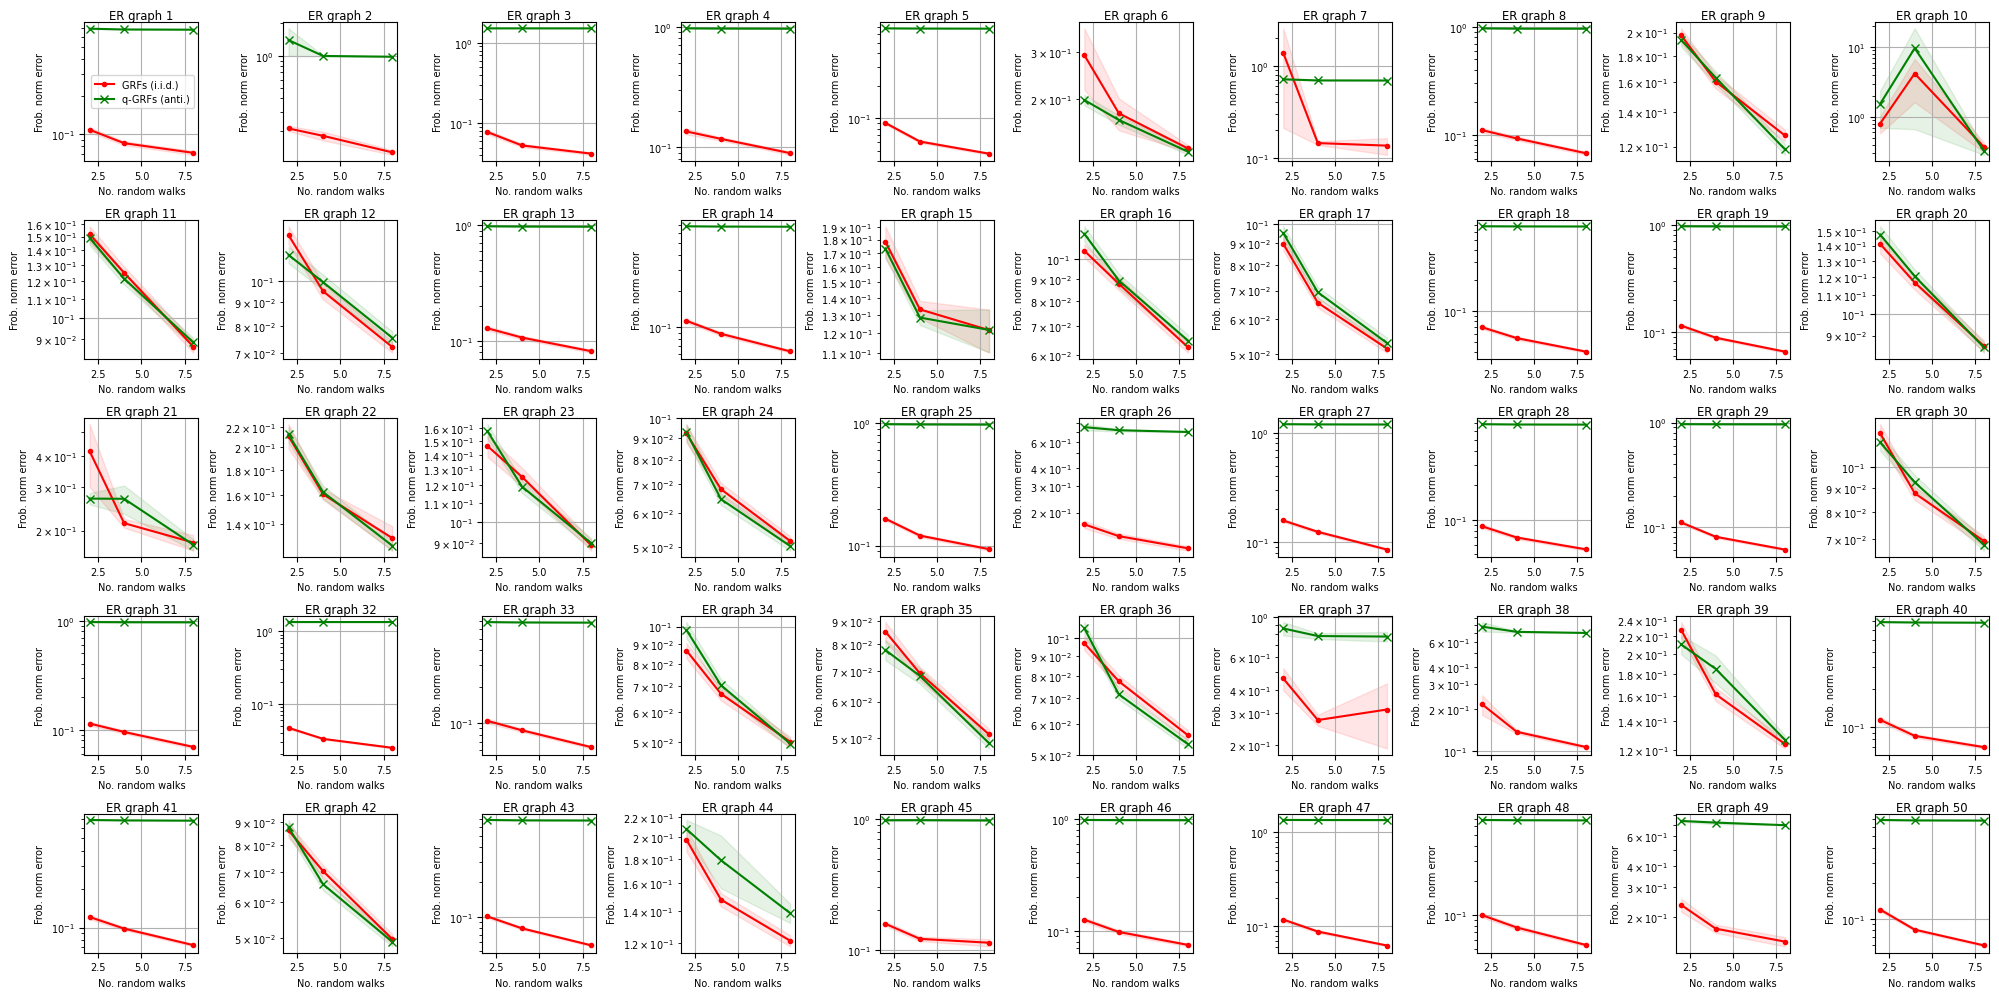

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_graphs_means, all_graphs_stds, nb_repeats, nb_rnd_walks_list are defined

# Define colors, markers, and labels for the plots
colors = ['red', 'green']
markers = ['.', 'x']
labels = ['GRFs (i.i.d.)', 'q-GRFs (anti.)']

# Update font size for the plot
plt.rcParams.update({'font.size': 7})

# Create subplots
fig, axes = plt.subplots(5, 10, figsize=(20, 10))

# Generate titles for each subplot (ER graphs)
titles = [f'ER graph {i+1}' for i in range(50)]

# Iterate over each graph
for graph_id in range(50):
    this_graph_means = all_graphs_means[graph_id]
    this_graph_stds = all_graphs_stds[graph_id]

    # Select the subplot for the current graph
    ax = axes[graph_id // 10, graph_id % 10]

    # Plot the error for both iid and anti
    for ind in range(2):
        meanst = np.array(this_graph_means[ind])
        sdt = np.asarray(this_graph_stds[ind]) / np.sqrt(nb_repeats)

        # Set y-axis to logarithmic scale
        ax.set_yscale('log')

        # Plot the mean error with standard deviation as shaded area
        ax.plot(nb_rnd_walks_list, meanst, color=colors[ind], marker=markers[ind], label=labels[ind])
        ax.fill_between(nb_rnd_walks_list, meanst - sdt, meanst + sdt, color=colors[ind], alpha=0.1)

    # Add legend to the first subplot
    if graph_id == 0:
        ax.legend()

    # Set title, grid, and labels for the subplot
    ax.set_title(titles[graph_id], pad=2)
    ax.grid()
    ax.set_ylabel('Frob. norm error')
    ax.set_xlabel('No. random walks')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


Erdős–Rényi Model -- 100 spin


In [ ]:
#Parameters
nb_rnd_walks_list = [2,4,8]     #number of walkers to use to estimate kernel
nb_repeats = 100        #number of repeats to get standard deviations
p_halt = 0.5         #probability of a walker halting at a particular timestep
sigma = 0.1   #regulariser

In [ ]:
#load adjacency matrix arrays for the graphs to be considered
with open('ER_100spin_p15_50graphs.pkl','rb') as f:
    As = pickle.load(f)

In [ ]:
#Heat Kernel for ER Models

all_graphs_means = [] #holders for the mean approximation error and corresponding standard deviation
all_graphs_stds = []


for graph_id,A in enumerate(As):
    print('Doing graph %s of %s'%(graph_id+1, len(As)))

    nb_vertices = len(A)    #size of the graph
    L_tilde = heat_kernel(A)  #see Eq. 24
    U = - sigma**2 / (1+sigma**2) * (L_tilde - np.eye(len(A)))  #see Eq. 26
    M = np.eye(nb_vertices) + sigma**2 * L_tilde
    groundtruth_matrix = np.linalg.inv(M @ M)  #see Eq. 25

    adj_lists, weight_lists = adj_matrix_to_lists(U)  #get lists of neighbours and weights for each edge

    mean_fro_superlist = []  #to hold all the mean Frob norm errors
    std_fro_superlist = []  #to hold their respctive standard devs


    #iid walkers
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling = None)  #create low rank factorisation
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)  #compute product of random features to approximate Gram matrix
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)    #compute the relative Frob norm between the true and approximated Gram matrices
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    #antithetic termination -- repeat the above with our new QMC scheme
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling='antithetic')
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    all_graphs_means.append(mean_fro_superlist)
    all_graphs_stds.append(std_fro_superlist)
    print('')

Doing graph 1 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 197.67it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 104.83it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 61.28it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:01<00:00, 51.29it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:02<00:00, 40.87it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:04<00:00, 20.59it/s]



Doing graph 2 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 206.39it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 117.43it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 180.25it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 159.75it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 89.68it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 47.76it/s]



Doing graph 3 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 399.42it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 347.55it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 175.69it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 169.10it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 84.38it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:03<00:00, 32.23it/s]



Doing graph 4 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 225.79it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 145.98it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 157.72it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 131.60it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 86.29it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 48.40it/s]



Doing graph 5 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 382.52it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 289.70it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 166.67it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 150.99it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 90.31it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 47.66it/s]



Doing graph 6 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 456.68it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 171.83it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 94.52it/s] 


Number of random walks is:  2


100%|██████████| 100/100 [00:01<00:00, 90.09it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 63.61it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 49.32it/s]



Doing graph 7 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 363.87it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 321.45it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 176.59it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 162.57it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 88.82it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 46.66it/s]



Doing graph 8 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 412.59it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 198.06it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 84.42it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:02<00:00, 41.36it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:02<00:00, 36.05it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 37.26it/s]



Doing graph 9 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 399.62it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 297.60it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 163.78it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 127.47it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 85.16it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 46.44it/s]



Doing graph 10 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 407.64it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 162.13it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 97.62it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:01<00:00, 95.84it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 58.33it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 46.84it/s]



Doing graph 11 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 387.38it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 296.17it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 191.72it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 170.00it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 84.85it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 46.92it/s]



Doing graph 12 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 494.52it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 274.84it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 187.75it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 155.05it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 56.15it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:03<00:00, 32.44it/s]



Doing graph 13 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 493.84it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 277.09it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 173.33it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 151.08it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 84.71it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 40.03it/s]



Doing graph 14 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 346.75it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 292.01it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 180.62it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 154.87it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 90.67it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:03<00:00, 28.75it/s]



Doing graph 15 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 208.51it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 264.41it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 192.52it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 158.60it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 88.32it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 46.91it/s]



Doing graph 16 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 402.41it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 333.51it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 184.67it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 169.79it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 91.59it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 45.44it/s]



Doing graph 17 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 127.01it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 154.56it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 97.30it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:01<00:00, 90.86it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 89.40it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 48.46it/s]



Doing graph 18 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 362.18it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 321.27it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 181.58it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 153.85it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 86.91it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 47.83it/s]



Doing graph 19 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 368.19it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 323.15it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 182.95it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 109.42it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:02<00:00, 35.06it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 49.68it/s]



Doing graph 20 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 470.02it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 303.58it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 190.20it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 160.34it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 88.41it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 48.68it/s]



Doing graph 21 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 512.90it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 334.15it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 172.29it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 164.23it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 85.83it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:03<00:00, 28.04it/s]



Doing graph 22 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 371.64it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 295.71it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 196.48it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 155.45it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 93.03it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 48.77it/s]



Doing graph 23 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 372.19it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 332.93it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 189.42it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 154.53it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 93.96it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 41.45it/s]



Doing graph 24 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 174.50it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 147.57it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 107.95it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:01<00:00, 97.23it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 90.10it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 46.57it/s]



Doing graph 25 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 321.43it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 315.03it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 195.16it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 159.04it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 83.47it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 46.81it/s]



Doing graph 26 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 402.18it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 308.38it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 189.93it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 116.56it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:02<00:00, 45.57it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 39.41it/s]



Doing graph 27 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 258.01it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 272.87it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 171.65it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 168.59it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 89.03it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 48.34it/s]



Doing graph 28 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 461.68it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 317.63it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 171.95it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 167.38it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 90.48it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:03<00:00, 28.16it/s]



Doing graph 29 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 317.37it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 277.86it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 199.21it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 152.99it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 92.70it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 47.67it/s]



Doing graph 30 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 395.78it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 307.87it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 182.66it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 148.89it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 88.55it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 43.40it/s]



Doing graph 31 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 221.31it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 143.83it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 100.24it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:01<00:00, 94.42it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 76.16it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 46.37it/s]



Doing graph 32 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 362.53it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 267.75it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 155.44it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 160.41it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 87.99it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 46.97it/s]



Doing graph 33 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 413.46it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 280.05it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 187.13it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 131.01it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 54.75it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 36.89it/s]



Doing graph 34 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 364.40it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 301.40it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 176.42it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 155.87it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 88.37it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 48.34it/s]



Doing graph 35 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 439.09it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 287.45it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 112.46it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 144.67it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 86.09it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:03<00:00, 27.22it/s]



Doing graph 36 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 361.58it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 300.62it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 174.34it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 159.24it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 89.43it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 47.70it/s]



Doing graph 37 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 382.14it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 317.44it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 184.66it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 156.23it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 90.40it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:03<00:00, 30.36it/s]



Doing graph 38 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 236.94it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 169.66it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 105.29it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 158.17it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 94.18it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 48.97it/s]



Doing graph 39 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 380.82it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 295.55it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 203.58it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 160.64it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 92.64it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 49.07it/s]



Doing graph 40 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 489.48it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 287.81it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 187.78it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 105.22it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 50.20it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 38.31it/s]



Doing graph 41 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 402.45it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 302.78it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 186.15it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 164.72it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 89.89it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 47.21it/s]



Doing graph 42 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 413.70it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 300.79it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 184.80it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 161.08it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 89.60it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:03<00:00, 30.07it/s]



Doing graph 43 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 249.89it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 193.56it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 180.67it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 163.31it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 88.52it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 48.04it/s]



Doing graph 44 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 442.39it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 296.41it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 181.39it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 158.26it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 76.57it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 46.95it/s]



Doing graph 45 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 265.96it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 158.53it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 113.23it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:01<00:00, 93.25it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 66.70it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 49.20it/s]



Doing graph 46 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 399.37it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 333.03it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 182.08it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 166.33it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 86.51it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 47.37it/s]



Doing graph 47 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 418.49it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 333.82it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 186.76it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 169.50it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 58.19it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:03<00:00, 31.51it/s]



Doing graph 48 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 398.07it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 329.25it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 190.64it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 160.51it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 89.29it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 48.96it/s]



Doing graph 49 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 360.36it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 313.92it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 183.41it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 160.24it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 88.40it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 36.16it/s]



Doing graph 50 of 50
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 248.68it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 173.08it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 108.68it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 139.86it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:01<00:00, 86.64it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:02<00:00, 48.09it/s]

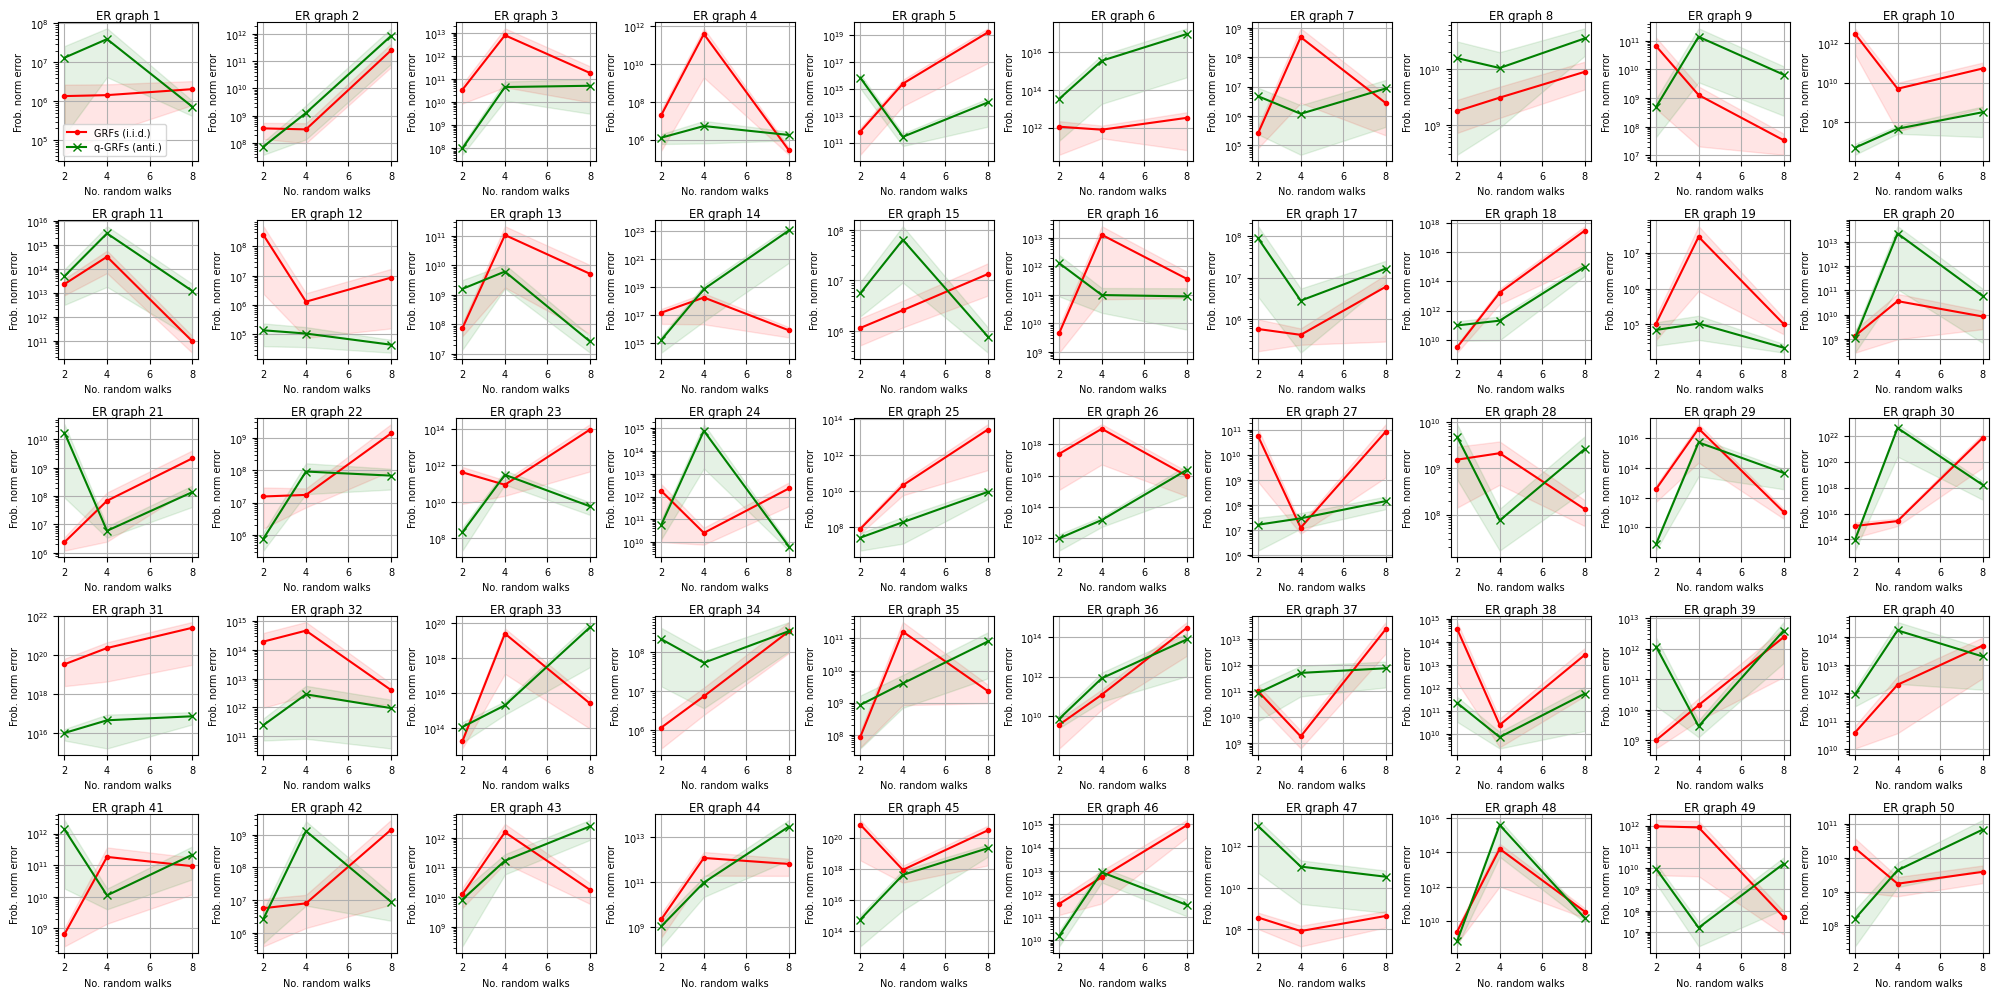

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_graphs_means, all_graphs_stds, nb_repeats, nb_rnd_walks_list are defined

# Define colors, markers, and labels for the plots
colors = ['red', 'green']
markers = ['.', 'x']
labels = ['GRFs (i.i.d.)', 'q-GRFs (anti.)']

# Update font size for the plot
plt.rcParams.update({'font.size': 7})

# Create subplots
fig, axes = plt.subplots(5, 10, figsize=(20, 10))

# Generate titles for each subplot (ER graphs)
titles = [f'ER graph {i+1}' for i in range(50)]

# Iterate over each graph
for graph_id in range(50):
    this_graph_means = all_graphs_means[graph_id]
    this_graph_stds = all_graphs_stds[graph_id]

    # Select the subplot for the current graph
    ax = axes[graph_id // 10, graph_id % 10]

    # Plot the error for both iid and anti
    for ind in range(2):
        meanst = np.array(this_graph_means[ind])
        sdt = np.asarray(this_graph_stds[ind]) / np.sqrt(nb_repeats)

        # Set y-axis to logarithmic scale
        ax.set_yscale('log')

        # Plot the mean error with standard deviation as shaded area
        ax.plot(nb_rnd_walks_list, meanst, color=colors[ind], marker=markers[ind], label=labels[ind])
        ax.fill_between(nb_rnd_walks_list, meanst - sdt, meanst + sdt, color=colors[ind], alpha=0.1)

    # Add legend to the first subplot
    if graph_id == 0:
        ax.legend()

    # Set title, grid, and labels for the subplot
    ax.set_title(titles[graph_id], pad=2)
    ax.grid()
    ax.set_ylabel('Frob. norm error')
    ax.set_xlabel('No. random walks')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


Barabási–Albert Graphs

In [ ]:
#Parameters
nb_rnd_walks_list = [2,4,8]     #number of walkers to use to estimate kernel
nb_repeats = 100        #number of repeats to get standard deviations
p_halt = 0.5         #probability of a walker halting at a particular timestep
sigma = 0.1   #regulariser

In [ ]:
#load adjacency matrix arrays for the graphs to be considered
with open('BA_100spin_m4_50graphs.pkl','rb') as f:
    As = pickle.load(f)

In [ ]:
#Heat Kernel for BA Models

# Set seeds for reproducibility
seed = 30
np.random.seed(seed)
random.seed(seed)

all_graphs_means = [] #holders for the mean approximation error and corresponding standard deviation
all_graphs_stds = []


for graph_id,A in enumerate(As):
    print('Doing graph %s of %s'%(graph_id+1, len(As)))

    nb_vertices = len(A)    #size of the graph
    L_tilde = heat_kernel(A)  #see Eq. 24
    U = - sigma**2 / (1+sigma**2) * (L_tilde - np.eye(len(A)))  #see Eq. 26
    M = np.eye(nb_vertices) + sigma**2 * L_tilde
    groundtruth_matrix = np.linalg.inv(M @ M)  #see Eq. 25

    adj_lists, weight_lists = adj_matrix_to_lists(U)  #get lists of neighbours and weights for each edge

    mean_fro_superlist = []  #to hold all the mean Frob norm errors
    std_fro_superlist = []  #to hold their respctive standard devs


    #iid walkers
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling = None)  #create low rank factorisation
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)  #compute product of random features to approximate Gram matrix
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)    #compute the relative Frob norm between the true and approximated Gram matrices
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    #antithetic termination -- repeat the above with our new QMC scheme
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling='antithetic')
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    all_graphs_means.append(mean_fro_superlist)
    all_graphs_stds.append(std_fro_superlist)
    print('')

Doing graph 1 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 29.88it/s]
<ipython-input-35-d6c780d4c66a>:45: RuntimeWarning: invalid value encountered in scalar subtract
  std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 16.36it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.02it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.79it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.15it/s]
<ipython-input-35-d6c780d4c66a>:69: RuntimeWarning: invalid value encountered in scalar subtract
  std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.36it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]



Doing graph 2 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 28.29it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 14.70it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.41it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]



Doing graph 3 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 28.20it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 16.89it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.35it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:07<00:00,  1.33it/s]



Doing graph 4 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 14.59it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.98it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.32it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]



Doing graph 5 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 27.32it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 16.25it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.27it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  6.23it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.16it/s]



Doing graph 6 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 26.26it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 15.59it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.37it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.37it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:06<00:00,  1.43it/s]



Doing graph 7 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 28.73it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 15.56it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.21it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  7.46it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.32it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]



Doing graph 8 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 25.79it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 13.64it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.44it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.77it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.31it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]



Doing graph 9 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 24.05it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 14.66it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  7.83it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.03it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]



Doing graph 10 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 29.85it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 14.76it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.22it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:01<00:00,  5.00it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:07<00:00,  1.32it/s]



Doing graph 11 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 17.93it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  9.60it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.96it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.37it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]



Doing graph 12 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 33.74it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 15.34it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.39it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  5.84it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.25it/s]



Doing graph 13 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 22.59it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 16.39it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.34it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  7.91it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.31it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]



Doing graph 14 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 34.82it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 14.18it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.42it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  5.78it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.46it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.25it/s]



Doing graph 15 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 28.09it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 15.99it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.24it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.78it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.11it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]



Doing graph 16 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 22.58it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 15.56it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.65it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.32it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]



Doing graph 17 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 30.35it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 15.56it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.43it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.92it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]



Doing graph 18 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 28.21it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  8.69it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  5.09it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.77it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  7.70it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.26it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]



Doing graph 19 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 20.77it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  8.48it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  5.18it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.43it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]



Doing graph 20 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 31.20it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 15.61it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.40it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.80it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  7.80it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.11it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]



Doing graph 21 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 28.90it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 15.49it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.30it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.32it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]



Doing graph 22 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 28.05it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 14.48it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.49it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.81it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.07it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:06<00:00,  1.44it/s]



Doing graph 23 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 32.73it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 12.71it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:02<00:00,  4.93it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.11it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.27it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]



Doing graph 24 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 26.07it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 15.16it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.25it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.17it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]



Doing graph 25 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 14.60it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 10.12it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  6.30it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  7.72it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.35it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]



Doing graph 26 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 30.21it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 14.73it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.41it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.91it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]



Doing graph 27 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 19.23it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 14.26it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.27it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.78it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  7.85it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.18it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:04<00:00,  2.24it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]



Doing graph 28 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 30.10it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 14.31it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.49it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.07it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]



Doing graph 29 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 25.05it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 15.98it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.29it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.77it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.23it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.38it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:06<00:00,  1.47it/s]



Doing graph 30 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 33.74it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 16.43it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.14it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.46it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]



Doing graph 31 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 29.78it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 16.18it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.36it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.83it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.54it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Number of random walks is:  100


 90%|█████████ | 9/10 [00:06<00:00,  1.47it/s]<ipython-input-35-d6c780d4c66a>:63: RuntimeWarning: overflow encountered in matmul
  approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)
100%|██████████| 10/10 [00:06<00:00,  1.46it/s]



Doing graph 32 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 26.41it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 13.19it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.26it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.42it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]



Doing graph 33 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 28.31it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 15.03it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.23it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.87it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.28it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]



Doing graph 34 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 19.30it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  8.39it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.75it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.20it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]



Doing graph 35 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 32.19it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 15.30it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.31it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  7.30it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.68it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:07<00:00,  1.31it/s]



Doing graph 36 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 17.62it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 10.07it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.36it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  7.98it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.14it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:07<00:00,  1.30it/s]



Doing graph 37 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 25.60it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 15.92it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.39it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.40it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  5.57it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:02<00:00,  4.61it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]



Doing graph 38 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 28.06it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.30it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.05it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]



Doing graph 39 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 30.22it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 15.31it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.06it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.35it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]



Doing graph 40 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 27.05it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 15.05it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.39it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.48it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:02<00:00,  4.67it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:06<00:00,  1.48it/s]



Doing graph 41 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 28.34it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 11.71it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  5.08it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.02it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.38it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]



Doing graph 42 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 29.58it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 16.65it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.29it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.91it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  7.97it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]



Doing graph 43 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 20.50it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 10.78it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  5.13it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.17it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]



Doing graph 44 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 26.82it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 13.78it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.47it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  7.57it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]



Doing graph 45 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 15.63it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  8.46it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.81it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.15it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]



Doing graph 46 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 29.07it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 15.34it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.21it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.91it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  5.70it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]



Doing graph 47 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 14.94it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  8.43it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.77it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  7.81it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.05it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]



Doing graph 48 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 26.93it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 15.50it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.39it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.22it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:08<00:00,  1.25it/s]



Doing graph 49 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 25.33it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 13.91it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.36it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.32it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]



Doing graph 50 of 50
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 26.19it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 15.62it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  7.32it/s]


Number of random walks is:  100


 60%|██████    | 6/10 [00:01<00:01,  3.15it/s]<ipython-input-35-d6c780d4c66a>:39: RuntimeWarning: overflow encountered in matmul
  approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)  #compute product of random features to approximate Gram matrix
100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:01<00:00,  7.58it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:01<00:00,  5.08it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:07<00:00,  1.25it/s]

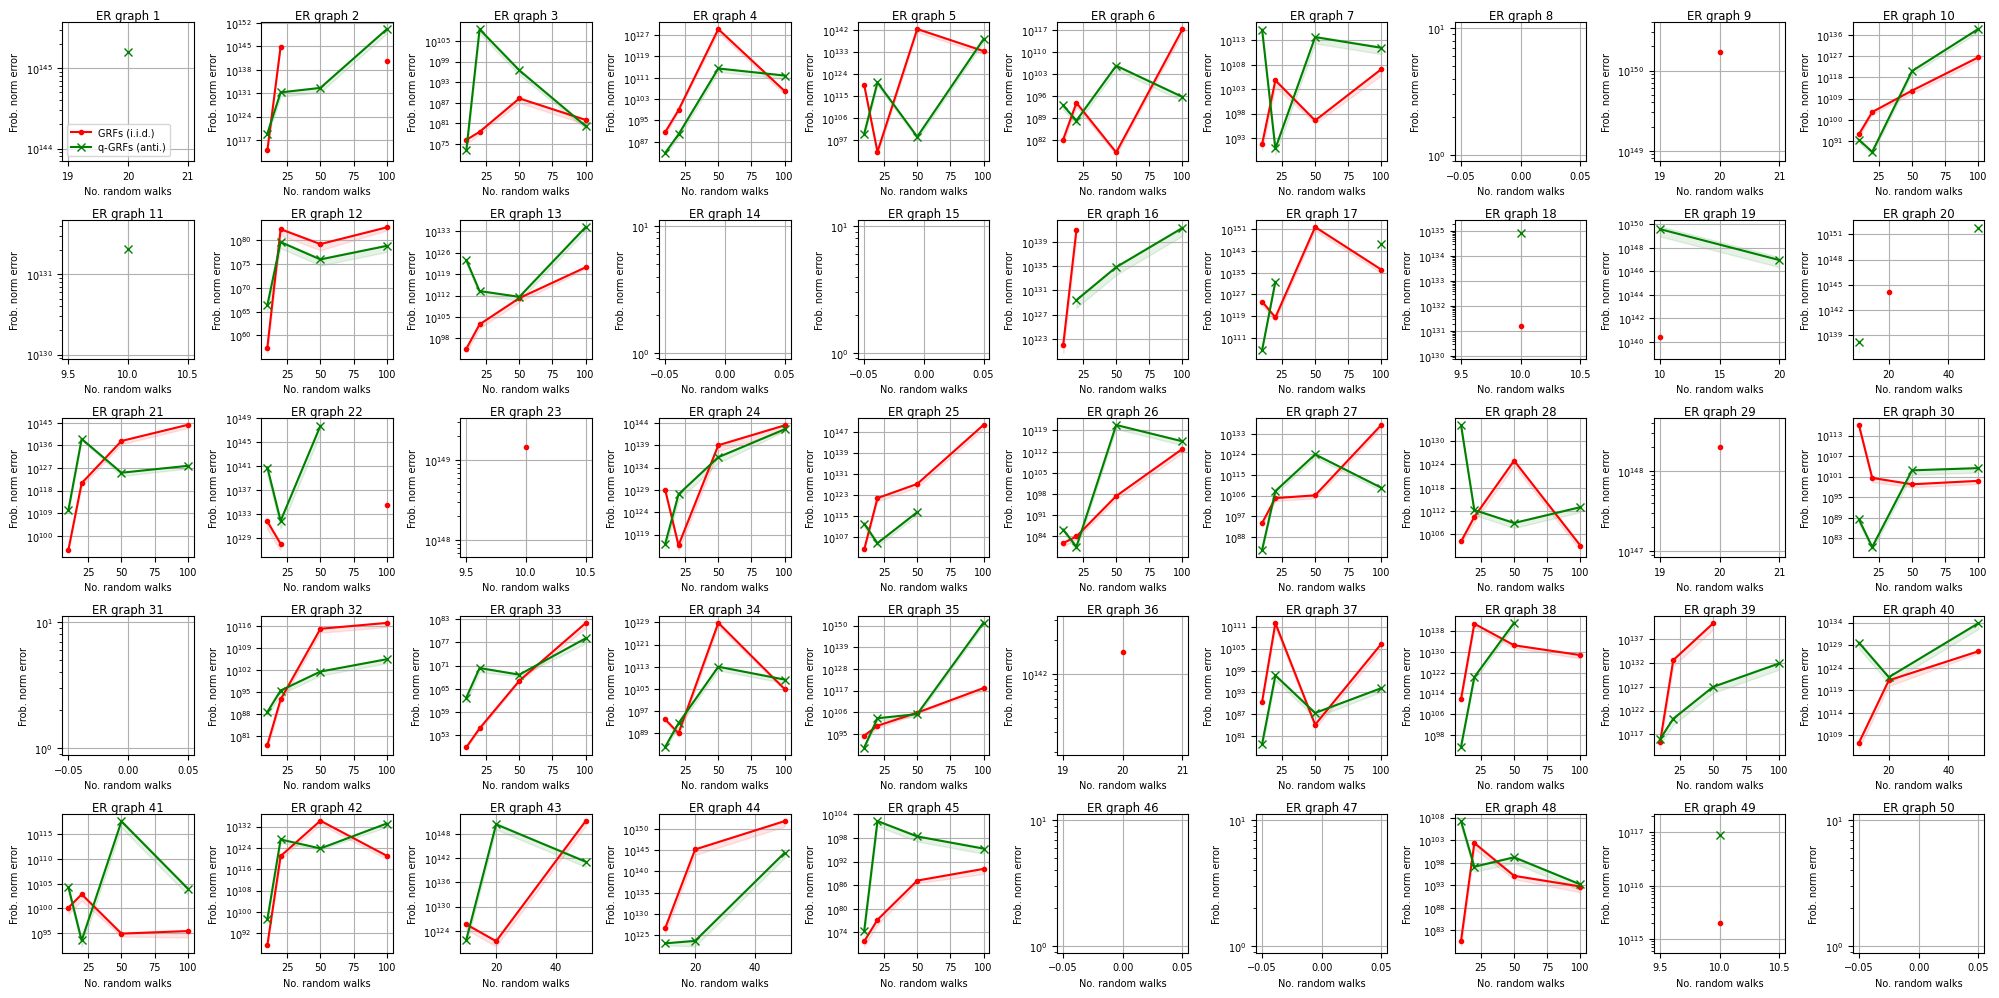

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_graphs_means, all_graphs_stds, nb_repeats, nb_rnd_walks_list are defined

# Define colors, markers, and labels for the plots
colors = ['red', 'green']
markers = ['.', 'x']
labels = ['GRFs (i.i.d.)', 'q-GRFs (anti.)']

# Update font size for the plot
plt.rcParams.update({'font.size': 7})

# Create subplots
fig, axes = plt.subplots(5, 10, figsize=(20, 10))

# Generate titles for each subplot (ER graphs)
titles = [f'ER graph {i+1}' for i in range(50)]

# Iterate over each graph
for graph_id in range(50):
    this_graph_means = all_graphs_means[graph_id]
    this_graph_stds = all_graphs_stds[graph_id]

    # Select the subplot for the current graph
    ax = axes[graph_id // 10, graph_id % 10]

    # Plot the error for both iid and anti
    for ind in range(2):
        meanst = np.array(this_graph_means[ind])
        sdt = np.asarray(this_graph_stds[ind]) / np.sqrt(nb_repeats)

        # Set y-axis to logarithmic scale
        ax.set_yscale('log')

        # Plot the mean error with standard deviation as shaded area
        ax.plot(nb_rnd_walks_list, meanst, color=colors[ind], marker=markers[ind], label=labels[ind])
        ax.fill_between(nb_rnd_walks_list, meanst - sdt, meanst + sdt, color=colors[ind], alpha=0.1)

    # Add legend to the first subplot
    if graph_id == 0:
        ax.legend()

    # Set title, grid, and labels for the subplot
    ax.set_title(titles[graph_id], pad=2)
    ax.grid()
    ax.set_ylabel('Frob. norm error')
    ax.set_xlabel('No. random walks')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

Installing binary tree package to generate a binary tree graph

In [ ]:
pip install binarytree

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.8 MB/s eta 0:00:00


Doing graph 1 of 1
Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 65.16it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 37.35it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:00<00:00, 18.72it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:01<00:00,  9.04it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:00<00:00, 24.63it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:00<00:00, 12.27it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:01<00:00,  5.43it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


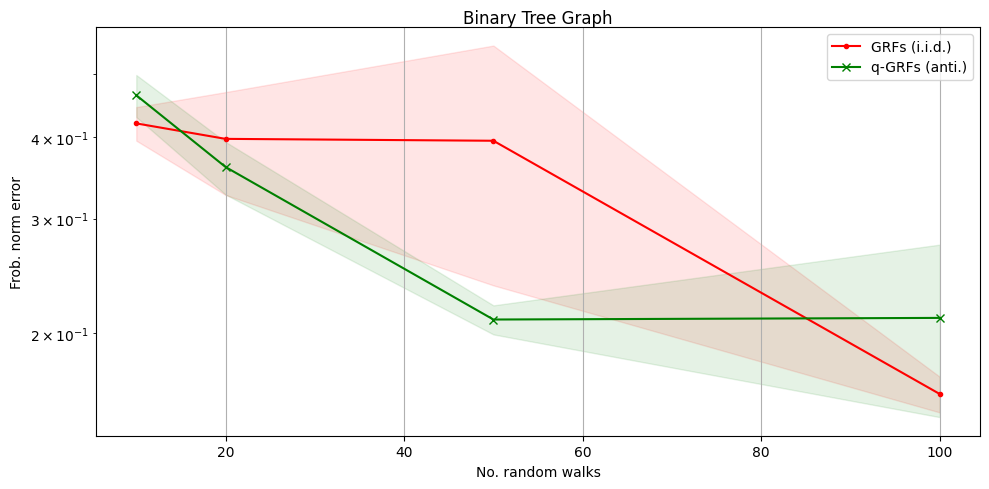

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import expm
from tqdm import tqdm
from binarytree import build

# Function to convert a binary tree to an adjacency matrix
def binary_tree_to_adj_matrix(tree):
    nodes = list(tree.inorder)  # Get the nodes in an inorder traversal
    n = len(nodes)
    node_index = {node: i for i, node in enumerate(nodes)}
    adj_matrix = np.zeros((n, n))
    for node in nodes:
        if node.left:
            adj_matrix[node_index[node]][node_index[node.left]] = 1
            adj_matrix[node_index[node.left]][node_index[node]] = 1
        if node.right:
            adj_matrix[node_index[node]][node_index[node.right]] = 1
            adj_matrix[node_index[node.right]][node_index[node]] = 1
    return adj_matrix

# Generate a binary tree
values = [i for i in range(31)]  # Example values for a binary tree with 31 nodes
binary_tree = build(values)
A = binary_tree_to_adj_matrix(binary_tree)

# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)

# Define colors, markers, and labels for the plots
colors = ['red', 'green']
markers = ['.', 'x']
labels = ['GRFs (i.i.d.)', 'q-GRFs (anti.)']

# Function to compute the degree matrix
def degree_matrix(adjacency_matrix):
    return np.diag(adjacency_matrix.sum(axis=1))

# Function to compute the unnormalized Laplacian
def unnormalized_laplacian(adjacency_matrix):
    D = degree_matrix(adjacency_matrix)
    return D - adjacency_matrix

# Function to compute the heat kernel
def heat_kernel(adjacency_matrix, t=0.5):
    L = unnormalized_laplacian(adjacency_matrix)
    return expm(-t * L)

# Example adjacency matrices for binary tree graphs
sigma = 0.5
p_halt = 0.1
nb_rnd_walks_list = [10, 20, 50, 100]  # Example random walks list
nb_repeats = 10  # Number of repeats

all_graphs_means = []  # Holders for the mean approximation error and corresponding standard deviation
all_graphs_stds = []

# Generate the heat kernel and other necessary matrices
print('Doing graph 1 of 1')

nb_vertices = len(A)  # Size of the graph
L_tilde = heat_kernel(A)  # See Eq. 24
U = -sigma**2 / (1 + sigma**2) * (L_tilde - np.eye(len(A)))  # See Eq. 26
M = np.eye(nb_vertices) + sigma**2 * L_tilde
groundtruth_matrix = np.linalg.inv(M @ M)  # See Eq. 25

adj_lists, weight_lists = adj_matrix_to_lists(U)  # Get lists of neighbors and weights for each edge

mean_fro_superlist = []  # To hold all the mean Frob norm errors
std_fro_superlist = []  # To hold their respective standard devs

# iid walkers
mean_fro_list = []
std_fro_list = []
for index in range(len(nb_rnd_walks_list)):
    print("Number of random walks is: ", nb_rnd_walks_list[index])
    nb_random_walks = nb_rnd_walks_list[index]
    mean_fro = 0
    sum_squares = 0
    for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(
            adj_lists, weight_lists, p_halt, nb_random_walks, term_coupling=None
        )  # Create low rank factorisation
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2) ** 2)  # Compute product of random features to approximate Gram matrix
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix, relative=True)  # Compute the relative Frob norm between the true and approximated Gram matrices
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
    mean_fro /= nb_repeats
    std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
    mean_fro_list.append(mean_fro)
    std_fro_list.append(std_fro)
mean_fro_superlist.append(mean_fro_list)
std_fro_superlist.append(std_fro_list)

# Antithetic termination -- repeat the above with our new QMC scheme
mean_fro_list = []
std_fro_list = []
for index in range(len(nb_rnd_walks_list)):
    print("Number of random walks is: ", nb_rnd_walks_list[index])
    nb_random_walks = nb_rnd_walks_list[index]
    mean_fro = 0
    sum_squares = 0
    for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(
            adj_lists, weight_lists, p_halt, nb_random_walks, term_coupling='antithetic'
        )
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2) ** 2)
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix, relative=True)
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
    mean_fro /= nb_repeats
    std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
    mean_fro_list.append(mean_fro)
    std_fro_list.append(std_fro)
mean_fro_superlist.append(mean_fro_list)
std_fro_superlist.append(std_fro_list)

all_graphs_means.append(mean_fro_superlist)
all_graphs_stds.append(std_fro_superlist)
print('')

# Plotting the results
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Plot the error for both iid and anti
for ind in range(2):
    meanst = np.array(all_graphs_means[0][ind])
    sdt = np.asarray(all_graphs_stds[0][ind]) / np.sqrt(nb_repeats)

    # Set y-axis to logarithmic scale
    ax.set_yscale('log')

    # Plot the mean error with standard deviation as shaded area
    ax.plot(nb_rnd_walks_list, meanst, color=colors[ind], marker=markers[ind], label=labels[ind])
    ax.fill_between(nb_rnd_walks_list, meanst - sdt, meanst + sdt, color=colors[ind], alpha=0.1)

# Add legend
ax.legend()

# Set title, grid, and labels for the plot
ax.set_title('Binary Tree Graph', pad=2)
ax.grid()
ax.set_ylabel('Frob. norm error')
ax.set_xlabel('No. random walks')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


Installing networkx package to generate a ladder graph

Doing graph 1 of 1
Number of random walks is:  10


100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Number of random walks is:  100


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Number of random walks is:  10


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Number of random walks is:  20


100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Number of random walks is:  50


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


Number of random walks is:  100


100%|██████████| 10/10 [00:31<00:00,  3.15s/it]


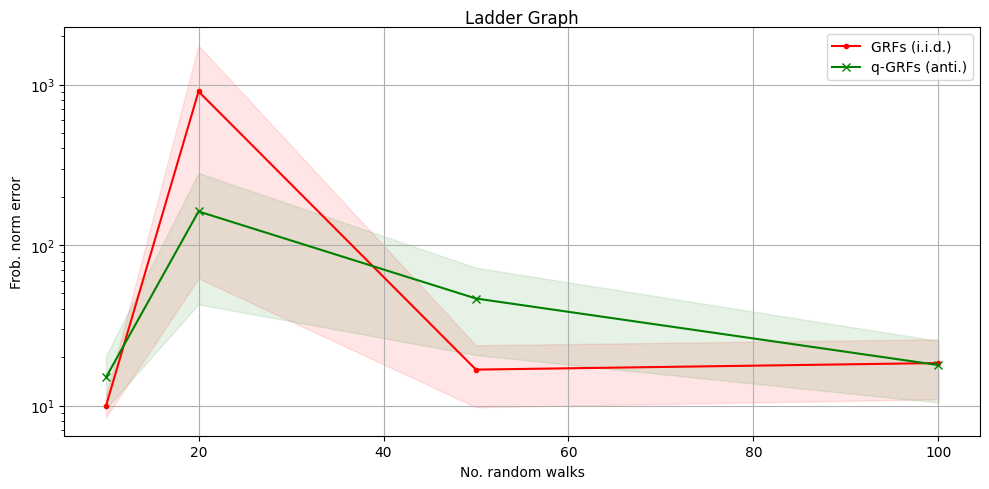

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import expm
from tqdm import tqdm
import networkx as nx

# Function to convert a NetworkX graph to an adjacency matrix
def graph_to_adj_matrix(graph):
    return nx.to_numpy_array(graph)

# Generate a ladder graph using NetworkX
n = 200  # Number of rungs in the ladder
ladder = nx.ladder_graph(n)
A = graph_to_adj_matrix(ladder)

# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)

# Define colors, markers, and labels for the plots
colors = ['red', 'green']
markers = ['.', 'x']
labels = ['GRFs (i.i.d.)', 'q-GRFs (anti.)']

# Function to compute the degree matrix
def degree_matrix(adjacency_matrix):
    return np.diag(adjacency_matrix.sum(axis=1))

# Function to compute the unnormalized Laplacian
def unnormalized_laplacian(adjacency_matrix):
    D = degree_matrix(adjacency_matrix)
    return D - adjacency_matrix

# Function to compute the heat kernel
def heat_kernel(adjacency_matrix, t=0.5):
    L = unnormalized_laplacian(adjacency_matrix)
    return expm(-t * L)

# Example adjacency matrices for ladder graphs
sigma = 0.5
p_halt = 0.1
nb_rnd_walks_list = [10, 20, 50, 100]  # Example random walks list
nb_repeats = 10  # Number of repeats

all_graphs_means = []  # Holders for the mean approximation error and corresponding standard deviation
all_graphs_stds = []

# Generate the heat kernel and other necessary matrices
print('Doing graph 1 of 1')

nb_vertices = len(A)  # Size of the graph
L_tilde = heat_kernel(A)  # See Eq. 24
U = -sigma**2 / (1 + sigma**2) * (L_tilde - np.eye(len(A)))  # See Eq. 26
M = np.eye(nb_vertices) + sigma**2 * L_tilde
groundtruth_matrix = np.linalg.inv(M @ M)  # See Eq. 25

adj_lists, weight_lists = adj_matrix_to_lists(U)  # Get lists of neighbors and weights for each edge

mean_fro_superlist = []  # To hold all the mean Frob norm errors
std_fro_superlist = []  # To hold their respective standard devs

# iid walkers
mean_fro_list = []
std_fro_list = []
for index in range(len(nb_rnd_walks_list)):
    print("Number of random walks is: ", nb_rnd_walks_list[index])
    nb_random_walks = nb_rnd_walks_list[index]
    mean_fro = 0
    sum_squares = 0
    for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(
            adj_lists, weight_lists, p_halt, nb_random_walks, term_coupling=None
        )  # Create low rank factorisation
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2) ** 2)  # Compute product of random features to approximate Gram matrix
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix, relative=True)  # Compute the relative Frob norm between the true and approximated Gram matrices
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
    mean_fro /= nb_repeats
    std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
    mean_fro_list.append(mean_fro)
    std_fro_list.append(std_fro)
mean_fro_superlist.append(mean_fro_list)
std_fro_superlist.append(std_fro_list)

# Antithetic termination -- repeat the above with our new QMC scheme
mean_fro_list = []
std_fro_list = []
for index in range(len(nb_rnd_walks_list)):
    print("Number of random walks is: ", nb_rnd_walks_list[index])
    nb_random_walks = nb_rnd_walks_list[index]
    mean_fro = 0
    sum_squares = 0
    for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(
            adj_lists, weight_lists, p_halt, nb_random_walks, term_coupling='antithetic'
        )
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2) ** 2)
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix, relative=True)
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
    mean_fro /= nb_repeats
    std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
    mean_fro_list.append(mean_fro)
    std_fro_list.append(std_fro)
mean_fro_superlist.append(mean_fro_list)
std_fro_superlist.append(std_fro_list)

all_graphs_means.append(mean_fro_superlist)
all_graphs_stds.append(std_fro_superlist)
print('')

# Plotting the results
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Plot the error for both iid and anti
for ind in range(2):
    meanst = np.array(all_graphs_means[0][ind])
    sdt = np.asarray(all_graphs_stds[0][ind]) / np.sqrt(nb_repeats)

    # Set y-axis to logarithmic scale
    ax.set_yscale('log')

    # Plot the mean error with standard deviation as shaded area
    ax.plot(nb_rnd_walks_list, meanst, color=colors[ind], marker=markers[ind], label=labels[ind])
    ax.fill_between(nb_rnd_walks_list, meanst - sdt, meanst + sdt, color=colors[ind], alpha=0.1)

# Add legend
ax.legend()

# Set title, grid, and labels for the plot
ax.set_title('Ladder Graph', pad=2)
ax.grid()
ax.set_ylabel('Frob. norm error')
ax.set_xlabel('No. random walks')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
